In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mplcursors      # Allows interactive matplotlib graphs

# Used to smooth jagged histograms
from scipy.interpolate import BSpline
from scipy.ndimage.filters import gaussian_filter

# Local library to read and prep data from dmv akts events in splunk
import dmv_test_input as dti 

In [2]:
def read_log(case=1, field="duration"):
    # Read and prepare the dmv_akts. Case=1 ... sample ... =2 ... akts database

    df = dti.read_dmv_log(case=case)
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    df["passed"]  = (df.Result=="P")
    
    # Drop negative duration since they must be in error
    # Drop long durations because the chance of error is high
    
    df = df[ (df.duration>0) & (df.duration<120) & (df.elapsed<120)].reset_index()
    
    return df

df = read_log(case=2)
changept = 14.5
print(f'{changept=}')
col = ["ExamineeId", "TestStartDateTime", "TotalScore", "duration", "elapsed", "passed"]

Original length of sample data is 152519
2415 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1056 tests
changept=14.5


<IPython.core.display.Javascript object>


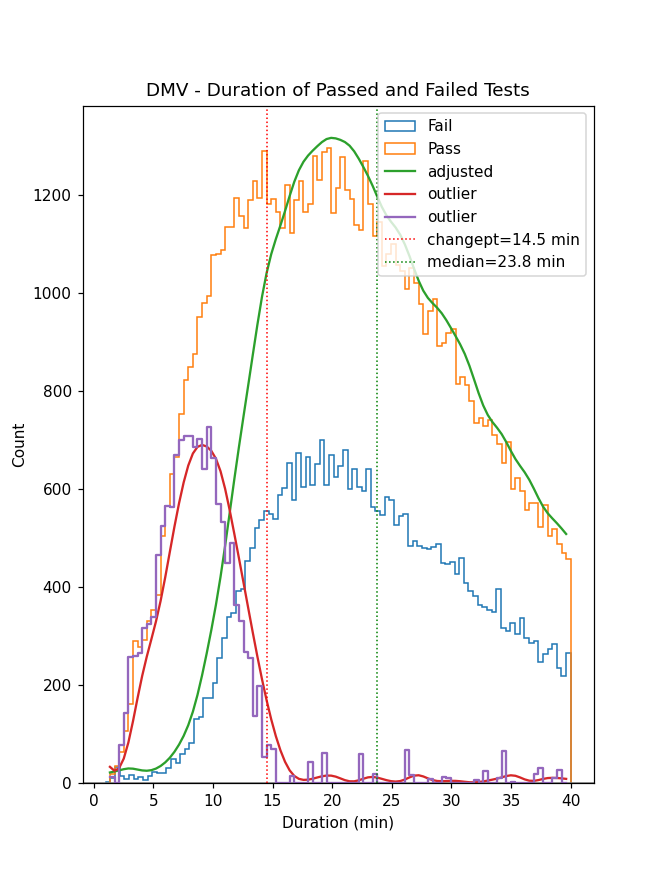

<IPython.core.display.Javascript object>


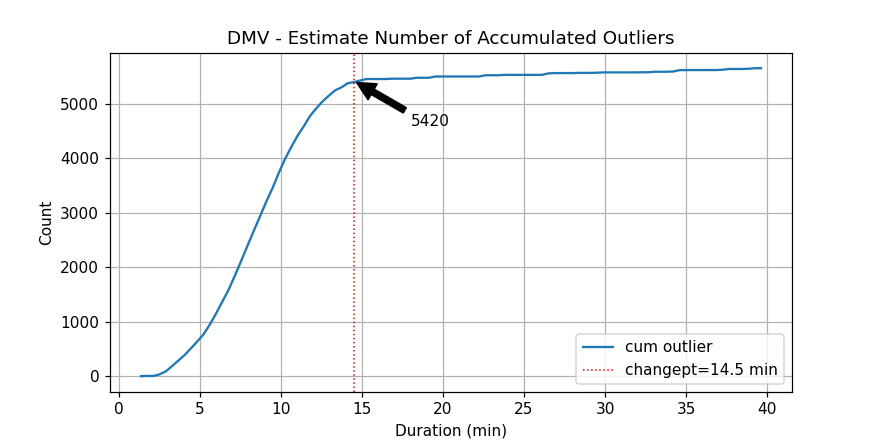

In [17]:
def draw_passfail_duration(x, changept, rate, fw=8, fh=4):
    # Graph compares tests that pass, fail to an estimate of outlier count
    # outliers are tests with scores higher than the long term average
    
    def smooth(x, y, order=3, num=100):
        # Smooth with a gaussian filter and then spline interpolation
        yfiltered = gaussian_filter(y, sigma=2)
        smoother = BSpline(x, yfiltered, order)
        u = np.linspace(x.min(), x.max(), num)

        return u, smoother(u)

    def draw_outlier_cum(p, changept, rate, median, fw=8, fh=4):
        # Draw the cumulative outliers
        # The number of outliers in each bin is count * binsize 
        binsize = p.duration.diff().mean()
        p['cum_outlier'] = p.outlier.cumsum()*binsize

        fig, ax = plt.subplots(figsize=(fw, fh))
        ax.plot(p.duration, p.cum_outlier, label='cum outlier')
        ax.axvline(x=changept, color="red", linewidth=1, ls=":", label=f"{changept=} min")
        xy = (14.5, 5420)
        xytext = (18, 4600)
        ax.annotate('5420', xy=xy, xytext=xytext, arrowprops=dict(facecolor='black', shrink=0.05))
        ax.set_title(f'DMV - Estimate Number of Accumulated Outliers')
        ax.set_xlabel(f'Duration (min)')
        ax.set_ylabel(f'Count')
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.show()
    
    # Find median of all the data
    median = x.duration.median()

    fig, ax = plt.subplots(figsize=(fw, fh))
    
    # Exclude tests that take a long time or have questionable time
    # Also minimizes the effect of long tail for short duration tests
    df = x[(x.duration > 0) & (x.duration <= 40) & (x.elapsed > 0) & (x.elapsed < 60)]
    
    # Draw histograms of the tests that pass and fail
    h1 = ax.hist(df[(df.Result!='P')].duration, bins=100, histtype="step", label="Fail")
    h2 = ax.hist(df[(df.Result=='P')].duration, bins=100, histtype="step", label="Pass")
    # Draw x=0 axis
    ax.axhline(y=0, color="gray", linewidth=1)

    # Use the counts calculated by plt.hist to find:
    # adjusted ... # tests expected to pass based on passing rate for duration > changept
    # outlier  ... # tests that occurred greater than the expected rate of passing
    # 
    # Exclude last duration, the outer edge of last bin. # duration & count must be same.
    # In following we use the calculated results made by plt.hist
    #    h1[0] ... counts of the people who failed in a duration bin
    #    h1[1] ... leading edge of the bin
    #    h2[0] ... counts of the people who passed in a duration bin
    #    h2[1] ... leading edge on the bin

    p = pd.DataFrame(h2[1][:-1], columns=['duration'])
    p['pass'] = h2[0]
    p['fail'] = h1[0]
    p['adjusted'] = p['fail']*(rate/(1. - rate))              # passing rate is .67
    p['outlier'] = p['pass'] - p['adjusted']
    # The number of outliers cannot be less than 0
    p['outlier'] = p['outlier'].apply(lambda x: x if x>0 else 0)

    # Smooth the jaggy histograms into a smooth curves
    u, v = smooth(p.duration, p.adjusted, order=2, num=100)
    h3 = ax.plot(u, v, label='adjusted')
#     h3 = ax.step(p.duration, p.adjusted, label='expected')

    u, v = smooth(p.duration, p.outlier, order=2, num=100)
    h4 = ax.plot(u, v, label='outlier')
    h5 = ax.step(p.duration, p['outlier'], label='outlier')

    # Display the changept and median
    ax.axvline(x=changept, color="red", linewidth=1, ls=":", label=f"{changept=} min")
    ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")

    ax.set_title(f'DMV - Duration of Passed and Failed Tests')
    ax.set_xlabel(f'Duration (min)')
    ax.set_ylabel(f'Count')
    ax.grid(False)
    ax.legend(loc='upper right')
    plt.show
    
    draw_outlier_cum(p, changept, rate, median)
    return h1, h2, h3, h4, h5, p

h1, h2, h3, h4, h5, p = draw_passfail_duration(df, 14.5, .67, fw=6, fh=8)

In [10]:
print(f"\nPassed tests:\n{p['pass'].agg(['mean', 'std'])}")
print(f"\nAdjusted:\n{p['adjusted'].agg(['mean', 'std'])}")


Passed tests:
mean    865.630000
std     334.615976
Name: pass, dtype: float64

Adjusted:
mean    750.298485
std     435.720609
Name: adjusted, dtype: float64


In [5]:
from scipy import stats
#Normat t-test assuming both distributions are normal
s1 = stats.ttest_ind(p['pass'], p['adjusted'])
print('Null hypothesis that passing distribution is same as adjusted')
print(f'Normal t-test, t-statistic is {s1[0]:.5f} pvalue is {s1[1]:5f}')

Null hypothesis that passing distribution is same as adjusted
Normal t-test, t-statistic is 2.09930 pvalue is 0.037058


In [6]:
#Normat t-test assuming both distributions are normal
s1 = stats.ttest_ind(p['pass'], p['adjusted'], alternative='two-sided')
print('Null hypothesis that passing distribution is same as adjusted')
print(f'Normal t-test, t-statistic is {s1[0]:.5f} pvalue is {s1[1]:5f}')


Null hypothesis that passing distribution is same as adjusted
Normal t-test, t-statistic is 2.09930 pvalue is 0.037058


In [7]:
# Permutation test
s1 = stats.ttest_ind(p['pass'], p['adjusted']
                     , alternative='two-sided'
                     , permutations=100000
                     , equal_var=False
                    )
print('Null hypothesis that passing distribution is same as adjusted')
print(f'Permutation test, t-statistic is {s1[0]:.5f} pvalue is {s1[1]:5f}')

Null hypothesis that passing distribution is same as adjusted
Permutation test, t-statistic is 2.09930 pvalue is 0.037770
